D:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
<ipython-input-1-73459acf6703>:36: RuntimeWarning: divide by zero encountered in double_scalars
  benefit = tp - fp * (threshold / (1 - threshold))
<ipython-input-1-73459acf6703>:36: RuntimeWarning: invalid value encountered in multiply
  benefit = tp - fp * (threshold / (1 - threshold))
<ipython-input-1-73459acf6703>:36: RuntimeWarning: divide by zero encountered in double_scalars
  benefit = tp - fp * (threshold / (1 - threshold))
<ipython-input-1-73459acf6703>:36: RuntimeWarning

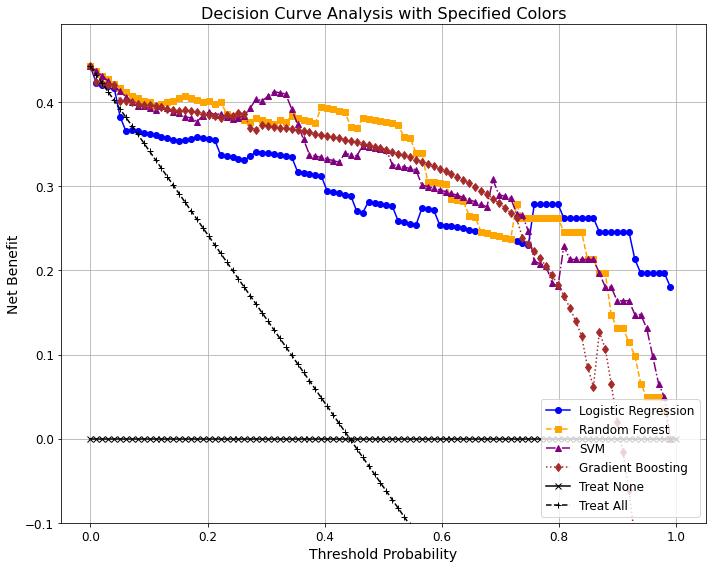

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
import matplotlib.pyplot as plt

# 加载数据集
file_path = 'D:\\ml\\DQ\\0904.xlsx' 
data = pd.read_excel(file_path)

# 分离特征和目标变量
X = data.drop('death', axis=1)
y = data['death']

# 数据分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# 初始化模型
logreg = LogisticRegression(max_iter=1000, random_state=42)
rf = RandomForestClassifier(random_state=42)
svm = SVC(probability=True, random_state=42)
gbc = GradientBoostingClassifier(random_state=42)

# 存储模型
models = {
    'Logistic Regression': logreg,
    'Random Forest': rf,
    'SVM': svm,
    'Gradient Boosting': gbc
}

# DCA函数
def net_benefit(tp, fp, tn, fn, threshold):
    benefit = tp - fp * (threshold / (1 - threshold))
    return benefit / (tp + fn + fp + tn)

def decision_curve_analysis(y_true, y_prob, thresholds):
    n = len(y_true)
    y_true = np.array(y_true)
    y_prob = np.array(y_prob)

    net_benefits = []
    for threshold in thresholds:
        tp = np.sum((y_prob >= threshold) & (y_true == 1))
        fp = np.sum((y_prob >= threshold) & (y_true == 0))
        tn = np.sum((y_prob < threshold) & (y_true == 0))
        fn = np.sum((y_prob < threshold) & (y_true == 1))

        nb = net_benefit(tp, fp, tn, fn, threshold)
        net_benefits.append(nb)

    return net_benefits

# 定义阈值
thresholds = np.linspace(0, 1, 100)

# 计算DCA
dca_results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    nb = decision_curve_analysis(y_test, y_pred_proba, thresholds)
    dca_results[name] = nb

# 'Treat none' 和 'Treat all' 线
treat_none = np.zeros_like(thresholds)
treat_all = np.array([np.mean(y_test) - t for t in thresholds])

# 计算最大净收益
max_net_benefit = max([max(nb) for nb in dca_results.values()] + [max(treat_all)])

# 绘制DCA图
plt.figure(figsize=(10, 8))

plt.plot(thresholds, dca_results['Logistic Regression'], label='Logistic Regression', color='blue', linestyle='-', marker='o')
plt.plot(thresholds, dca_results['Random Forest'], label='Random Forest', color='orange', linestyle='--', marker='s')
plt.plot(thresholds, dca_results['SVM'], label='SVM', color='purple', linestyle='-.', marker='^')
plt.plot(thresholds, dca_results['Gradient Boosting'], label='Gradient Boosting', color='brown', linestyle=':', marker='d')
plt.plot(thresholds, treat_none, 'k--', label='Treat None', linestyle='-', marker='x')
plt.plot(thresholds, treat_all, 'k:', label='Treat All', linestyle='--', marker='+')

# 自定义图形以提高可读性
plt.ylim(-0.1, max_net_benefit + 0.05)
plt.xlabel('Threshold Probability', fontsize=14)
plt.ylabel('Net Benefit', fontsize=14)
plt.title('Decision Curve Analysis with Specified Colors', fontsize=16)
plt.legend(loc='lower right', fontsize=12)
plt.grid(True)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()

# 显示图形
plt.savefig("dca_curve.pdf")
plt.show()
